In [16]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%autoreload 2

import copy
import functools
import itertools
import logging

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
# from progressbar import progressbar as pbar

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [15]:
logger.setLevel(logging.DEBUG)

In [19]:
volume = Volume.with_check(tomo2seg_data.VOLUME_PRECIPITATES_DRYRUN, "val")

[2020-10-28::23:13:41.789] tomo2seg :: DEBUG :: {data.py:with_check:162}
vol=Volume(name='PA66GF30_trans3_x__0_pag', version='val', _metadata=None)

[2020-10-28::23:13:41.790] tomo2seg :: WARNING :: {data.py:with_check:184}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.weights.raw

[2020-10-28::23:13:41.791] tomo2seg :: DEBUG :: {data.py:metadata:125}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.metadata.yml`.



In [22]:
dimensions = (500, 500, 500)
dtype = "uint8"  

# prefill the function `HST_read`
_hst_read = functools.partial(
    # from pymicro
    file_utils.HST_read,
    
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = copy.copy(volume.metadata.labels)

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [268]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy() 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')



## Validation volume

In [23]:
val_volume = hst_read(volume.data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

In [24]:
val_labels_volume = hst_read(volume.labels_path)
val_labels_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Model

In [25]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [33]:
model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

# Processing

In [10]:
n_z_layers = 100
volume = val_volume[:, :, :n_z_layers]
crop_shape = (224, 224, 1)

volume.shape
# slice_indices = tuple((c0, c0 + d) for c0, d in zip(slice_coord, slice_dims))
# (sx0, sx1), (sy0, sy1), (sz0, sz1) = slice_indices

(500, 500, 100)

## Generate the crops

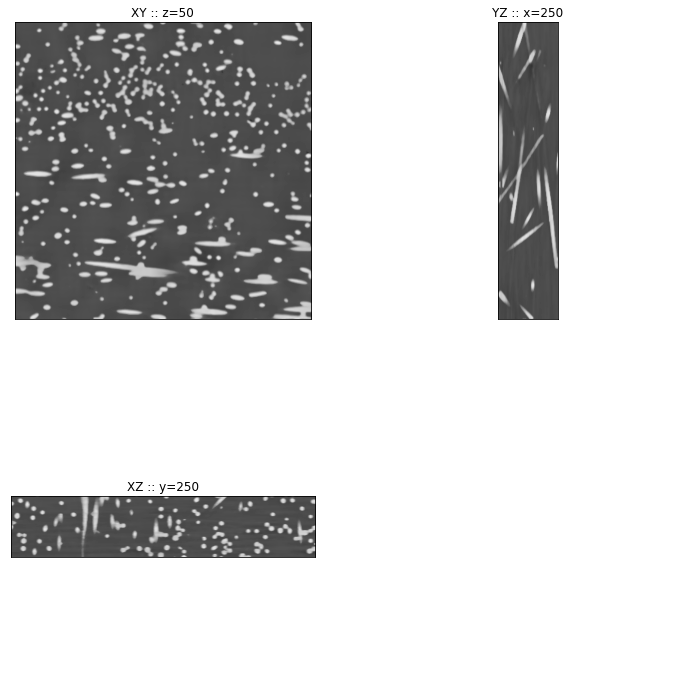

In [11]:
sz=12
fig, axs = plt.subplots(2, 2, figsize=(sz, sz))
viz.plot_orthogonal_slices(axs, volume)

In [12]:
n_steps = tuple(
    int(np.ceil(vol_dim / crop_dim))
    for vol_dim, crop_dim in zip(volume.shape, crop_shape)
)

n_steps

(3, 3, 100)

In [13]:
# coordinates (xs, ys, and zs) of the front upper left corners of the crops
x0s, y0s, z0s = tuple(
    tuple(map(
        int, 
        np.linspace(0, vol_dim - crop_dim, n)
    ))
    for vol_dim, crop_dim, n in zip(volume.shape, crop_shape, n_steps)
)
x0s, y0s, min(z0s), max(z0s), len(z0s)

((0, 138, 276), (0, 138, 276), 0, 99, 100)

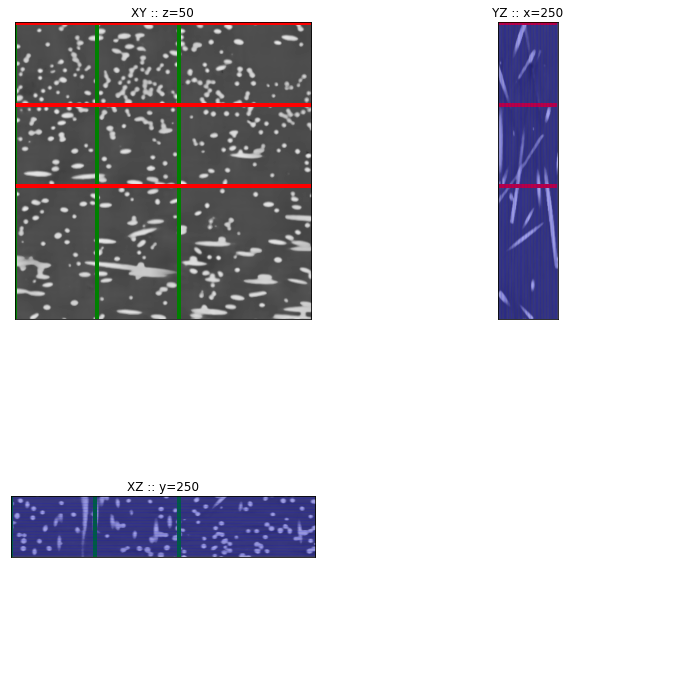

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(sz, sz))
viz.plot_orthogonal_slices(axs, volume)

ax_xy = axs[0, 0]
ax_yz = axs[0, 1]
ax_xz = axs[1, 0]

for x_ in x0s:
    ax_xy.vlines(x_, 0, volume.shape[0] - 1, color='g', linewidth=4)
    ax_xz.vlines(x_, 0, volume.shape[2] - 1, color='g', linewidth=4)

for y_ in y0s:
    ax_xy.hlines(y_, 0, volume.shape[1] - 1, color='r', linewidth=4)
    ax_yz.hlines(y_, 0, volume.shape[2] - 1, color='r', linewidth=4)

for z_ in z0s:
    ax_yz.vlines(z_, 0, volume.shape[0] - 1, color='b', linewidth=0.2)    
    ax_xz.hlines(z_, 0, volume.shape[1] - 1, color='b', linewidth=0.2)

In [94]:
crops_coordinates = np.array([
    (
        (x0, x0 + crop_shape[0]), 
        (y0, y0 + crop_shape[1]),
        (z0, z0 + crop_shape[2]),
    )
    for x0, y0, z0 in itertools.product(x0s, y0s, z0s)
], dtype=tuple).reshape(len(x0s), len(y0s), len(z0s), 3, 2)

logger.debug(f"{crops_coordinates.shape=}")

crops_coordinates[:, :, :1]

[2020-10-28::10:37:13.365] tomo2seg :: DEBUG :: {<ipython-input-94-ad729b68f83d>:<module>:010}
crops_coordinates.shape=(3, 3, 100, 3, 2)



array([[[[[0, 224],
          [0, 224],
          [0, 1]]],


        [[[0, 224],
          [138, 362],
          [0, 1]]],


        [[[0, 224],
          [276, 500],
          [0, 1]]]],



       [[[[138, 362],
          [0, 224],
          [0, 1]]],


        [[[138, 362],
          [138, 362],
          [0, 1]]],


        [[[138, 362],
          [276, 500],
          [0, 1]]]],



       [[[[276, 500],
          [0, 224],
          [0, 1]]],


        [[[276, 500],
          [138, 362],
          [0, 1]]],


        [[[276, 500],
          [276, 500],
          [0, 1]]]]], dtype=object)

In [98]:
crops_coordinates_sequential = crops_coordinates.reshape(-1, 3, 2, order='F')  # 'F' reshapes with x varying fastest and z slowest
logger.debug(f"{crops_coordinates_sequential.shape=}")
crops_coordinates_sequential[:18,]

[2020-10-28::10:41:11.623] tomo2seg :: DEBUG :: {<ipython-input-98-f8a6fb89856f>:<module>:002}
crops_coordinates_sequential.shape=(900, 3, 2)



array([[[0, 224],
        [0, 224],
        [0, 1]],

       [[138, 362],
        [0, 224],
        [0, 1]],

       [[276, 500],
        [0, 224],
        [0, 1]],

       [[0, 224],
        [138, 362],
        [0, 1]],

       [[138, 362],
        [138, 362],
        [0, 1]],

       [[276, 500],
        [138, 362],
        [0, 1]],

       [[0, 224],
        [276, 500],
        [0, 1]],

       [[138, 362],
        [276, 500],
        [0, 1]],

       [[276, 500],
        [276, 500],
        [0, 1]],

       [[0, 224],
        [0, 224],
        [1, 2]],

       [[138, 362],
        [0, 224],
        [1, 2]],

       [[276, 500],
        [0, 224],
        [1, 2]],

       [[0, 224],
        [138, 362],
        [1, 2]],

       [[138, 362],
        [138, 362],
        [1, 2]],

       [[276, 500],
        [138, 362],
        [1, 2]],

       [[0, 224],
        [276, 500],
        [1, 2]],

       [[138, 362],
        [276, 500],
        [1, 2]],

       [[276, 500],
        [276, 500]

[2020-10-28::10:48:32.567] tomo2seg :: INFO :: {<ipython-input-112-75da255f1289>:<module>:001}
Showing the first 3 z-direction slices

[2020-10-28::10:48:32.575] tomo2seg :: DEBUG :: {<ipython-input-112-75da255f1289>:<module>:026}
Changing z coordinate z0=0. Creating new fig.

[2020-10-28::10:48:32.687] tomo2seg :: DEBUG :: {<ipython-input-112-75da255f1289>:<module>:026}
Changing z coordinate z0=1. Creating new fig.

[2020-10-28::10:48:32.759] tomo2seg :: DEBUG :: {<ipython-input-112-75da255f1289>:<module>:026}
Changing z coordinate z0=2. Creating new fig.



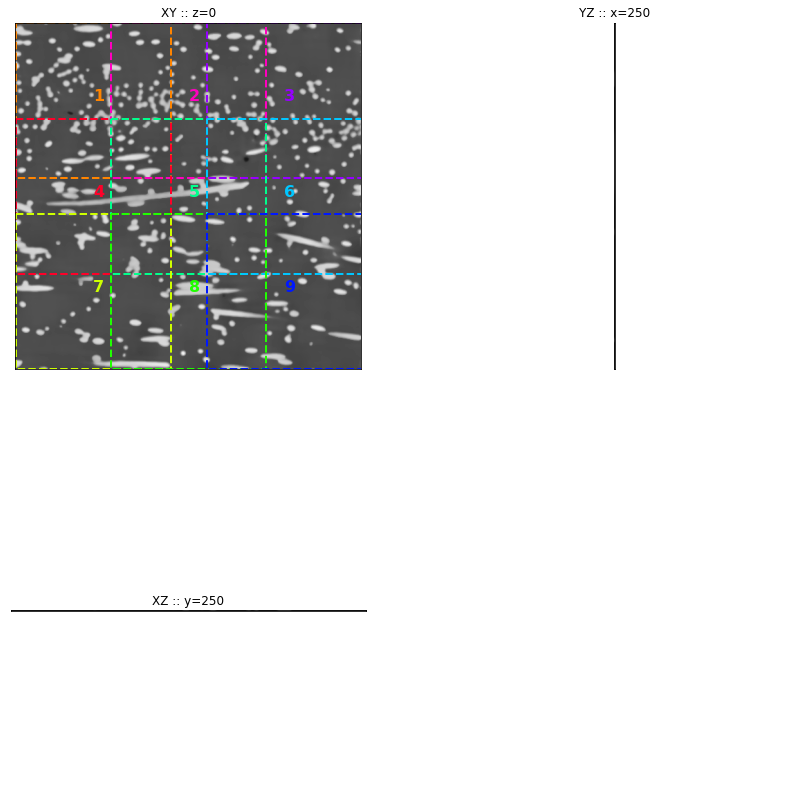

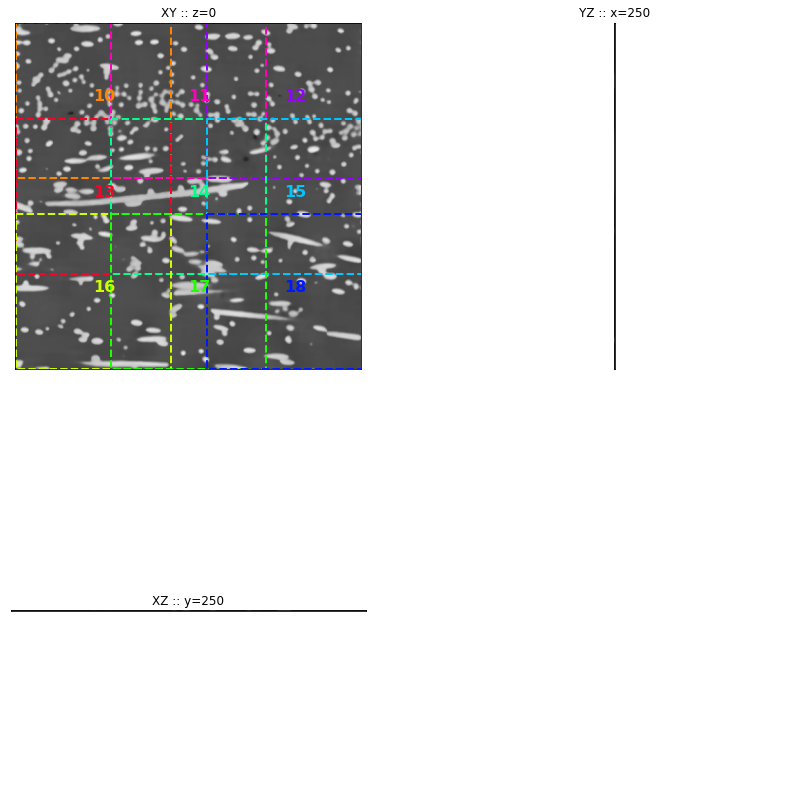

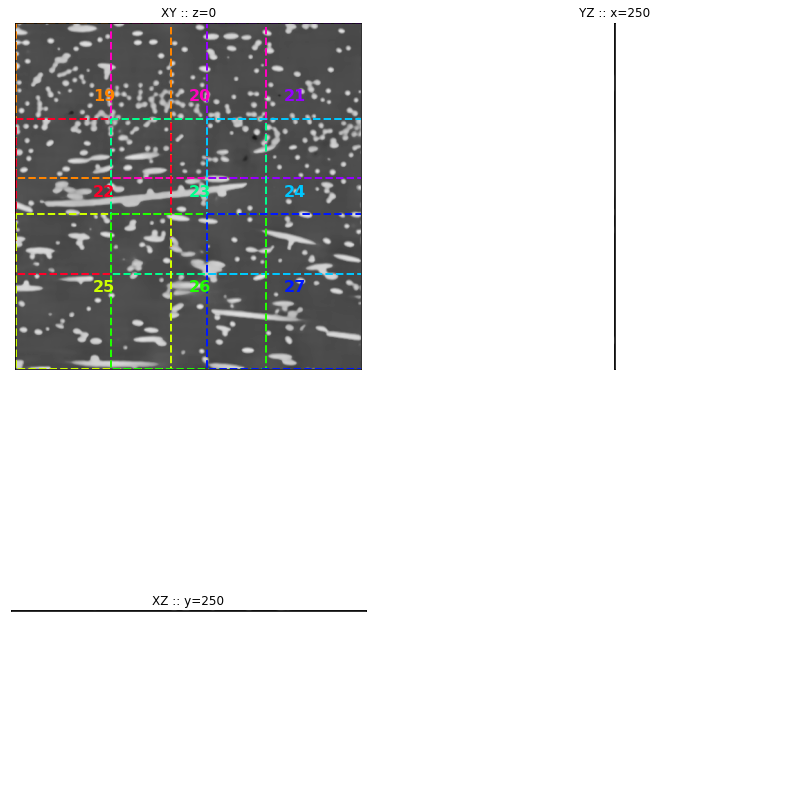

In [112]:
logger.info("Showing the first 3 z-direction slices")
    
get_frame = functools.partial(
    patches.Rectangle,
    linewidth=2,
    facecolor='none',
    ls="--"
)

sz = 14
last_z0 = None

# this is just a number beween 0 and 1 that represents
# the percentage of the linear path in the color space
rainbow = plt.get_cmap('gist_rainbow')

# 3 slices with 3x3 crops
color_indices = np.linspace(0, 1, 3 * 3).tolist()  
np.random.shuffle(color_indices)
color_indices = 3 * color_indices
colors = [rainbow(idx) for idx in color_indices]

for i, (((x0, x1), (y0, y1), (z0, z1)), color) in enumerate(zip(crops_coordinates_sequential, colors)):
    
    if z0 != last_z0:
        logger.debug(f"Changing z coordinate {z0=}. Creating new fig.")
        last_z0 = z0
        
        fig, axs = plt.subplots(2, 2, figsize=(sz, sz))
        viz.plot_orthogonal_slices(axs, z_slice := volume[:, :, z0:z1])
        ax_xy, ax_yz, ax_xz = axs[0, 0], axs[0, 1], axs[1, 0]
            
    frame = get_frame(
        xy := (x0, y0), width := x1 - x0, height := y1 - y0, edgecolor=color
    )
    ax_xy.add_patch(frame)
    ax_xy.text(x_middle := x0 + width / 2, y_middle := y0 + height / 2, f"{i+1}", fontsize=16, fontweight='bold', color=color)
    
    if i == len(color_indices) - 1:
        break

In [113]:
(x0, x1), (y0, y1), (z0, z1) = crops_coordinates[0, 0, 0].tolist()
f"An example of crops coordinates {(x0, x1), (y0, y1), (z0, z1)=}."

'An example of crops coordinates (x0, x1), (y0, y1), (z0, z1)=((0, 224), (0, 224), (0, 1)).'

In [116]:
f"{crops_coordinates.shape=}"

'crops_coordinates.shape=(3, 3, 100, 3, 2)'

In [120]:
target_shape = tuple(list(crops_coordinates.shape[:3]) + list(crop_shape))

logger.debug(f"{target_shape=}")

crops_sequential = np.array([
    volume[x0:x1, y0:y1, z0:z1] 
    for (x0, x1), (y0, y1), (z0, z1) in crops_coordinates_sequential
])

# 'F' reshapes with x varying fastest and z slowest
# this option is necessary because `crops_coordinates` was reshaped with it
crops = crops_sequential.reshape(target_shape, order="F")

logger.debug(f"{crops_sequential.shape=} {crops.shape=}")

[2020-10-28::10:53:34.999] tomo2seg :: DEBUG :: {<ipython-input-120-f18f857575d6>:<module>:003}
target_shape=(3, 3, 100, 224, 224, 1)

[2020-10-28::10:53:35.042] tomo2seg :: DEBUG :: {<ipython-input-120-f18f857575d6>:<module>:014}
crops_sequential.shape=(900, 224, 224, 1) crops.shape=(3, 3, 100, 224, 224, 1)



In [150]:
gridspace = .01
def one_slice_crops_subplots(sz):
    fig, axs = plt.subplots(
        nrows=6,
        ncols=6,
        figsize=(6 * sz, 6 * sz), 
        gridspec_kw={"wspace": gridspace, "hspace": .5 * gridspace}
    )
    for ax in axs.ravel():
        ax.axis("off")
    return fig, axs 

[2020-10-28::14:22:14.527] tomo2seg :: DEBUG :: {<ipython-input-178-63cd5814f42d>:<module>:007}
one_slice_crops.shape=(3, 3, 1, 224, 224, 1)

[2020-10-28::14:22:14.528] tomo2seg :: DEBUG :: {<ipython-input-178-63cd5814f42d>:<module>:010}
i, j, k=(0, 0, 0)

[2020-10-28::14:22:14.529] tomo2seg :: DEBUG :: {<ipython-input-178-63cd5814f42d>:<module>:015}
crop3d.shape=(224, 224, 1)

[2020-10-28::14:22:14.530] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(224, 224, 1)

[2020-10-28::14:22:14.531] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 255)

[2020-10-28::14:22:14.531] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-28::14:22:14.532] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:033}
xy_z_coord, yz_x_coord, xz_y_coord=(0, 112, 112)

[2020-10-28::14:22:14.535] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:040}
xy_slice.shape, yz_slice.shape, xz_slice.shape=((224, 224), (224, 1), (224, 1)

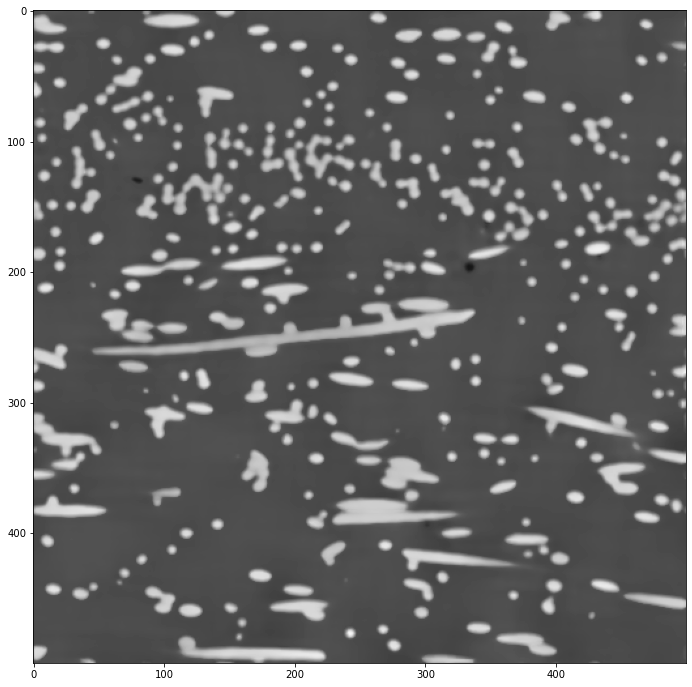

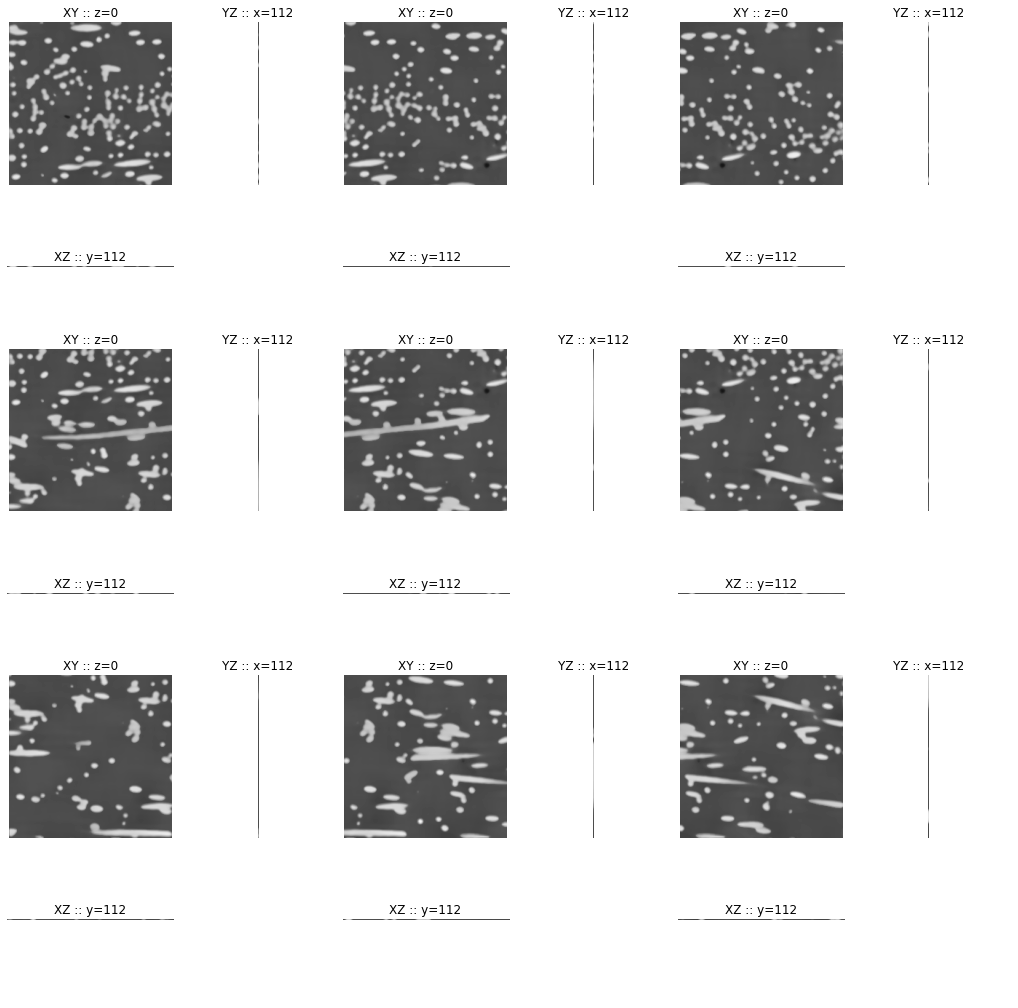

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(sz := 12, sz))
ax.imshow(volume[:, :, 0], vmin=0, vmax=255, cmap=cm.gray)

fig, axs = one_slice_crops_subplots(3)

one_slice_crops = crops[:, :, :1]
logger.debug(f"{one_slice_crops.shape=}")

for i, j, k in itertools.product(range(n_steps[0]), range(n_steps[1]), range(1)):
    logger.debug(f"{i, j, k=}")
    
    ortho_plot_axs = axs[i * 2:(i + 1) * 2, j * 2:(j + 1) * 2]
    crop3d = crops[i, j, k]
    
    logger.debug(f"{crop3d.shape=}")

    viz.plot_orthogonal_slices(ortho_plot_axs, crop3d)

## Segment

[2020-10-28::11:46:09.132] tomo2seg :: DEBUG :: {<ipython-input-163-c488081b6916>:<module>:004}
crop_data.shape=(224, 224, 1)

[2020-10-28::11:46:09.239] tomo2seg :: DEBUG :: {<ipython-input-163-c488081b6916>:<module>:008}
crop_data_modelin.shape=(1, 224, 224, 1) :: crop_probas_modelout.shape=(1, 224, 224, 3)

[2020-10-28::11:46:09.241] tomo2seg :: DEBUG :: {<ipython-input-163-c488081b6916>:<module>:013}
crop_probas.shape=(224, 224, 1, 3) :: (224, 224, 1)



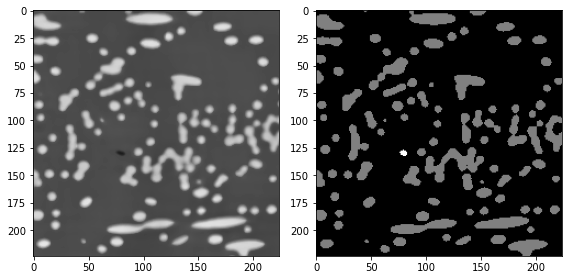

In [163]:
crop_ijk = (0, 0, 0)

crop_data = crops[crop_ijk[0], crop_ijk[1], crop_ijk[2]]
logger.debug(f"{crop_data.shape=}")

crop_data_modelin = crop_data.reshape(1, crop_shape[0], crop_shape[1], 1) / 255  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
crop_probas_modelout = model.predict(crop_data_modelin, batch_size=1)
logger.debug(f"{crop_data_modelin.shape=} :: {crop_probas_modelout.shape=}")

targe_probas_shape = list(crop_shape) + [crop_probas_modelout.shape[-1]]
crop_probas = crop_probas_modelout.reshape(targe_probas_shape)
crop_preds = crop_probas.argmax(axis=-1)
logger.debug(f"{crop_probas.shape=} :: {crop_preds.shape}")

sz = 8
fig = plt.figure(figsize=(sz, 2 * sz))
fig.set_tight_layout(True)

ax = plt.subplot(121)
ax.imshow(crop_data, vmin=0, vmax=255, cmap=cm.gray)

ax = plt.subplot(122)
plt.imshow(crop_preds, vmin=0, vmax=2, cmap=cm.gray)

In [166]:
proba_crops = np.empty(
    proba_crops_target_shape := list(crops.shape) + [3], 
    dtype=np.float
)
pred_crops = np.empty_like(crops)

logger.debug(f"{proba_crops.shape=} {proba_crops.dtype=}")
logger.debug(f"{pred_crops.shape=} {pred_crops.dtype=}")

[2020-10-28::11:51:12.086] tomo2seg :: DEBUG :: {<ipython-input-166-5cc40d90a064>:<module>:007}
proba_crops.shape=(3, 3, 100, 224, 224, 1, 3) proba_crops.dtype=dtype('float64')

[2020-10-28::11:51:12.088] tomo2seg :: DEBUG :: {<ipython-input-166-5cc40d90a064>:<module>:008}
pred_crops.shape=(3, 3, 100, 224, 224, 1) pred_crops.dtype=dtype('uint8')



In [173]:
ijk_iterator = list(itertools.product(*tuple(range(n_steps[dim]) for dim in range(3))))
logger.debug(f"{len(ijk_iterator)=}")

target_probas_shape = list(crop_shape) + [crop_probas_modelout.shape[-1]]

for i, j, k in pbar(ijk_iterator):
    model_in = crops[i, j, k].reshape(1, crop_shape[0], crop_shape[1], 1) / 255
    model_out = model.predict(model_in)
    
    proba_crops[i, j, k] = model_out.reshape(target_probas_shape)
    pred_crops[i, j, k] = proba_crops[i, j, k].argmax(axis=-1)

[2020-10-28::11:59:07.934] tomo2seg :: DEBUG :: {<ipython-input-173-efd396a139fd>:<module>:002}
len(ijk_iterator)=900



100% (900 of 900) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


[2020-10-28::14:54:38.005] tomo2seg :: DEBUG :: {<ipython-input-185-43946359c452>:<module>:015}
probas_crop3d.shape=(224, 224, 1, 3)



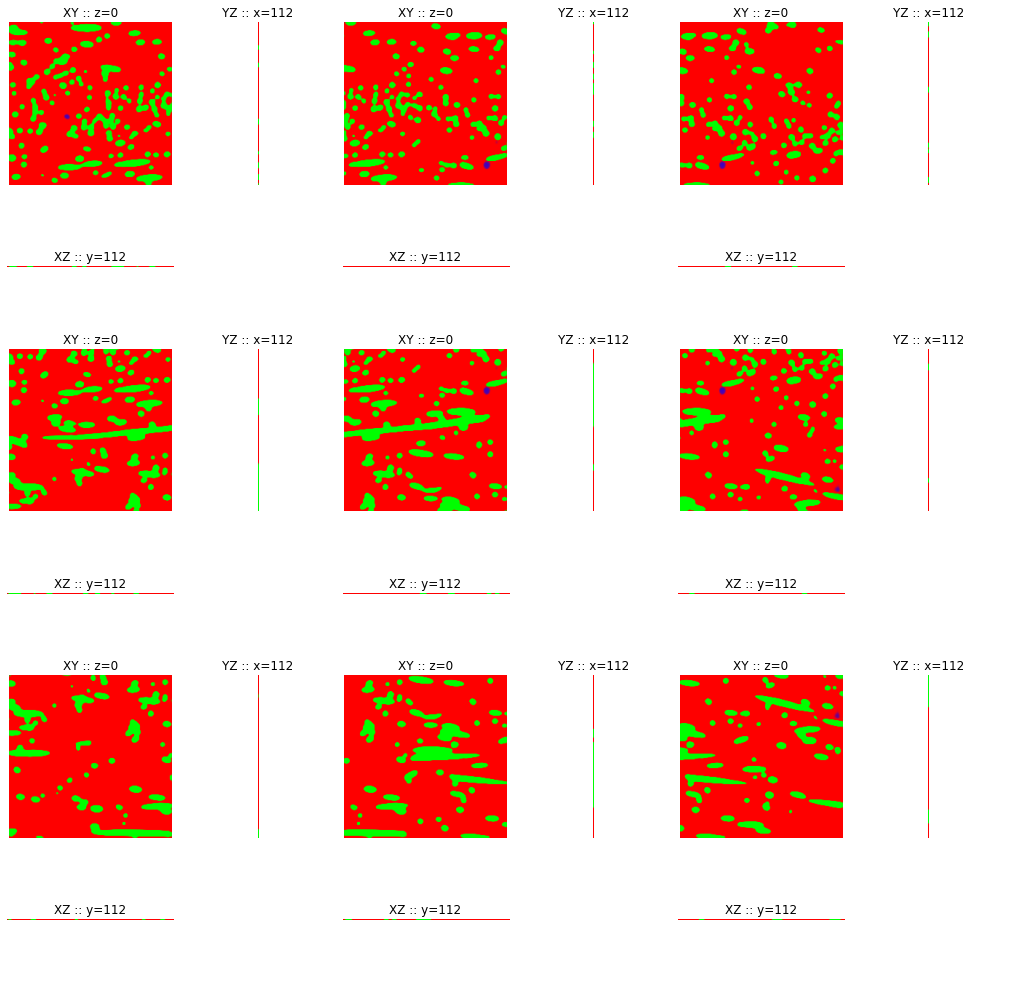

In [185]:
fig, axs = one_slice_crops_subplots(3)

logger.setLevel(logging.INFO)

for i, j, k in itertools.product(range(n_steps[0]), range(n_steps[1]), range(1)):
    logger.debug(f"{i, j, k=}")
    
    ortho_plot_axs = axs[i * 2:(i + 1) * 2, j * 2:(j + 1) * 2]
    probas_crop3d = proba_crops[i, j, k]
    
    viz.plot_orthogonal_slices(ortho_plot_axs, probas_crop3d, is_color=True)
  
logger.setLevel(logging.DEBUG)
logger.debug(f"{probas_crop3d.shape=}")

[2020-10-28::15:08:31.487] tomo2seg :: DEBUG :: {<ipython-input-189-7597fbd476ea>:<module>:013}
pred_crop3d.shape=(224, 224, 1)



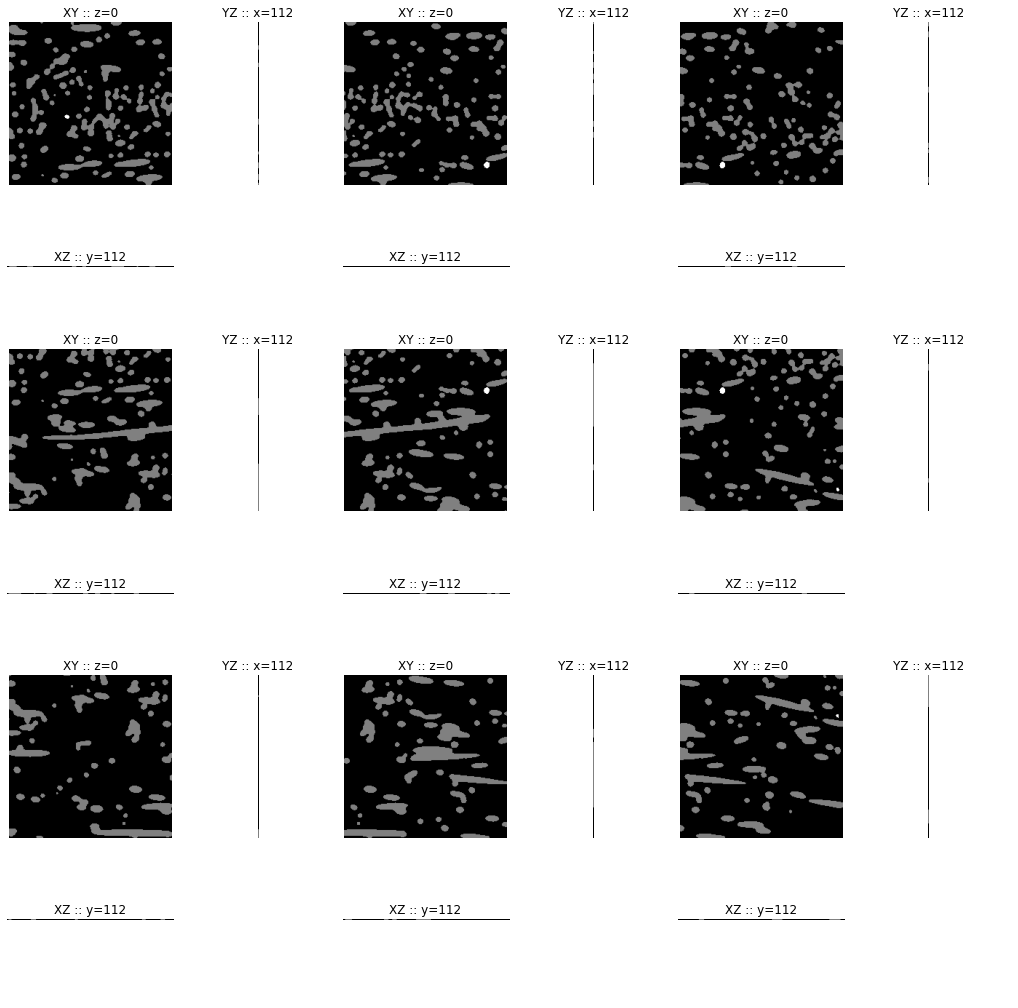

In [189]:
fig, axs = one_slice_crops_subplots(3)

logger.setLevel(logging.INFO)

for i, j, k in itertools.product(range(n_steps[0]), range(n_steps[1]), range(1)):
    logger.debug(f"{i, j, k=}")
    
    ortho_plot_axs = axs[i * 2:(i + 1) * 2, j * 2:(j + 1) * 2]
    pred_crop3d = pred_crops[i, j, k]
    viz.plot_orthogonal_slices(ortho_plot_axs, pred_crop3d, vrange=(0, 2))

logger.setLevel(logging.DEBUG)
logger.debug(f"{pred_crop3d.shape=}")

# Rebuild the volume

In [200]:
rebuilt_volume  = np.empty(volume.shape)
logger.debug(f"{rebuilt_volume.shape=}")

[2020-10-28::15:11:58.898] tomo2seg :: DEBUG :: {<ipython-input-200-1c9d2a03a406>:<module>:002}
rebuilt_volume.shape=(500, 500, 100)

[2020-10-28::15:11:58.900] tomo2seg :: DEBUG :: {<ipython-input-200-1c9d2a03a406>:<module>:005}
redundancies_count.shape=(500, 500, 100)



In [205]:
for coord, crop in pbar(zip(
    crops_coordinates_sequential,
    crops_sequential,
)):
    (x0, x1), (y0, y1), (z0, z1) = coord
    rebuilt_volume[x0:x1, y0:y1, z0:z1] = crop.copy()

| |    #                                            | 899 Elapsed Time: 0:00:00


In [206]:
np.all(rebuilt_volume == volume)

True

In [250]:
proba_sum_volume = np.zeros(target_proba_volume_shape := list(volume.shape) + [proba_crops.shape[-1]])
redundancies_count = np.zeros(proba_sum_volume.shape).max(axis=-1)  # only one channel

logger.debug(f"{target_proba_volume_shape=} :: {redundancies_count.shape=} :: {proba_sum_volume.shape=}")

[2020-10-28::15:44:49.680] tomo2seg :: DEBUG :: {<ipython-input-250-bfba71bf0781>:<module>:004}
target_proba_volume_shape=[500, 500, 100, 3] :: redundancies_count.shape=(500, 500, 100) :: proba_sum_volume.shape=(500, 500, 100, 3)



In [251]:
# 'F' reshapes with x varying fastest and z slowest
# this is necessary bcs `crops_coordinates_sequential` is 
# also reshaped like this
proba_crops_sequential = proba_crops.reshape(-1, *proba_crops.shape[3:], order='F')  
logger.debug(f"{proba_crops_sequential.shape=}")

for coord, proba_crop in pbar(zip(
    crops_coordinates_sequential,
    proba_crops_sequential,
)):
    (x0, x1), (y0, y1), (z0, z1) = coord
    proba_sum_volume[x0:x1, y0:y1, z0:z1] += proba_crop
    redundancies_count[x0:x1, y0:y1, z0:z1] += np.ones(crop_shape)

[2020-10-28::15:44:51.759] tomo2seg :: DEBUG :: {<ipython-input-251-cb52f13e35a4>:<module>:005}
proba_crops_sequential.shape=(900, 224, 224, 1, 3)



| |                                        #        | 899 Elapsed Time: 0:00:04


In [252]:
# check that the min and max probas are coherent with the min/max redundancy
logger.debug(f"{(min_proba_sum := proba_sum_volume.min(axis=0).min(axis=0).min(axis=0))=}")
logger.debug(f"{(max_proba_sum := proba_sum_volume.max(axis=0).max(axis=0).max(axis=0))=}")

logger.debug(f"{(min_redundancy := np.min(redundancies_count))=}")
logger.debug(f"{(max_redundancy := np.max(redundancies_count))=}")

assert np.all(min_proba_sum >= 0)
assert np.all(max_proba_sum <= max_redundancy)

[2020-10-28::15:44:55.961] tomo2seg :: DEBUG :: {<ipython-input-252-34aeabe9d01d>:<module>:002}
(min_proba_sum := proba_sum_volume.min(axis=0).min(axis=0).min(axis=0))=array([7.99094657e-09, 1.09509857e-09, 1.48143511e-11])

[2020-10-28::15:44:56.068] tomo2seg :: DEBUG :: {<ipython-input-252-34aeabe9d01d>:<module>:003}
(max_proba_sum := proba_sum_volume.max(axis=0).max(axis=0).max(axis=0))=array([4.       , 4.       , 3.0210709])

[2020-10-28::15:44:56.086] tomo2seg :: DEBUG :: {<ipython-input-252-34aeabe9d01d>:<module>:005}
(min_redundancy := np.min(redundancies_count))=1.0

[2020-10-28::15:44:56.104] tomo2seg :: DEBUG :: {<ipython-input-252-34aeabe9d01d>:<module>:006}
(max_redundancy := np.max(redundancies_count))=4.0



In [253]:
proba_volume = np.empty_like(proba_sum_volume)
logger.debug(f"{proba_volume.shape=}")

# divide each probability channel by the number of times it was summed (avg proba)
for klass_idx in range(proba_sum_volume.shape[-1]):
    proba_volume[:, :, :, klass_idx] =  proba_sum_volume[:, :, :, klass_idx] / redundancies_count

[2020-10-28::15:44:59.173] tomo2seg :: DEBUG :: {<ipython-input-253-2699c2601822>:<module>:002}
proba_volume.shape=(500, 500, 100, 3)



In [256]:
# check that proba distribs sum to 1
logger.debug(f"{(min_proba := proba_volume.min(axis=0).min(axis=0).min(axis=0))=}")
logger.debug(f"{(max_proba := proba_volume.max(axis=0).max(axis=0).max(axis=0))=}")

assert np.all(min_proba >= 0)
assert np.all(max_proba <= 1)

logger.debug(f"{(min_distrib_proba_sum := proba_volume.sum(axis=-1).min())=}")
logger.debug(f"{(max_distrib_proba_sum := proba_volume.sum(axis=-1).max())=}")

assert np.isclose(min_distrib_proba_sum, 1)
assert np.isclose(max_distrib_proba_sum, 1)

[2020-10-28::15:48:44.922] tomo2seg :: DEBUG :: {<ipython-input-256-44a002de06bf>:<module>:002}
(min_proba := proba_volume.min(axis=0).min(axis=0).min(axis=0))=array([7.99094657e-09, 1.09509857e-09, 1.48143511e-11])

[2020-10-28::15:48:45.026] tomo2seg :: DEBUG :: {<ipython-input-256-44a002de06bf>:<module>:003}
(max_proba := proba_volume.max(axis=0).max(axis=0).max(axis=0))=array([1.        , 1.        , 0.80795121])

[2020-10-28::15:48:45.565] tomo2seg :: DEBUG :: {<ipython-input-256-44a002de06bf>:<module>:008}
(min_distrib_proba_sum := proba_volume.sum(axis=-1).min())=0.9999998520761437

[2020-10-28::15:48:46.100] tomo2seg :: DEBUG :: {<ipython-input-256-44a002de06bf>:<module>:009}
(max_distrib_proba_sum := proba_volume.sum(axis=-1).max())=1.0000001476216767



In [260]:
pred_volume = proba_volume.argmax(axis=-1)

logger.debug(f"{pred_volume.shape=}   {pred_volume.min()=}   {pred_volume.max()=}")

[2020-10-28::15:50:21.343] tomo2seg :: DEBUG :: {<ipython-input-260-7be925d98b80>:<module>:003}
pred_volume.shape=(500, 500, 100)   pred_volume.min()=0   pred_volume.max()=2





# Save volumes

In [ ]:
with open("preds", "rb") as f:
    pred_volume = np.load(f)

In [ ]:
with open("probas", "rb") as f:
    proba_volume = np.load(f)

In [ ]:
with open("redundancies", "rb") as f:
    redundancies_count = np.load(f)

In [53]:
from tomo2seg.data import SetPartition

In [ ]:
data

In [61]:
partition_100layers = SetPartition.z_partitioned_only(500, 500, 0, 100, alias="first100layers")

In [63]:
estimation_volume = EstimationVolume.from_objects(volume=volume, model=model, set_partition=partition_100layers)
estimation_volume

EstimationVolume(volume_name='PA66GF30_trans3_x__0_pag', volume_version='val', model_name='dryrun-03', partition=SetPartition(x_range=(0, 500), y_range=(0, 500), z_range=(0, 100), alias='first100layers'), _metadata=None)

In [64]:
with (p := estimation_volume.probabilities_path).open("wb") as f:
    logger.debug(f"Writing probabilities on disk at `{str(p)}`")
    np.save(f, proba_volume)

[2020-10-29::08:09:26.215] tomo2seg :: DEBUG :: {<ipython-input-64-43570f12b809>:<module>:002}
Writing probabilities on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=first100layers.model=dryrun-03.probabilities.npy`



In [66]:
pred_volume = pred_volume.astype("uint8")

In [67]:
logger.debug(f"Writing predictions on disk at `{str(estimation_volume.predictions_path)}`")
file_utils.HST_write(pred_volume, str(estimation_volume.predictions_path))

[2020-10-29::08:09:35.942] tomo2seg :: DEBUG :: {<ipython-input-67-3257ca0207f6>:<module>:001}
Writing predictions on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=first100layers.model=dryrun-03.predictions.raw`

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=first100layers.model=dryrun-03.predictions.raw for writing in mode w
volume size is 500x500x100
data type is uint8
writing .info file
done with writing


In [68]:
klass = 2
logger.debug(f"Writing predictions on disk at `{(pat := str(str(estimation_volume.get_class_probability_path(klass))))=}`")
file_utils.HST_write(proba_volume[:, :, :, klass], pat)

[2020-10-29::08:09:36.832] tomo2seg :: DEBUG :: {data.py:metadata:125}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.metadata.yml`.

[2020-10-29::08:09:36.836] tomo2seg :: DEBUG :: {<ipython-input-68-96f70c8c94f5>:<module>:002}
Writing predictions on disk at `(pat := str(str(estimation_volume.get_class_probability_path(klass))))='/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=first100layers.model=dryrun-03.probability.class_idx=2.raw'`

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=first100layers.model=dryrun-03.probability.class_idx=2.raw for writing in mode w
volume size is 500x500x100
data type is float64
writing .info file
done with writing


# 